# Notebook 6: STR Locus Simulation and Pileup

This notebook moves from the theoretical foundations of STR alignment (Notebook 4) to practical simulation and application. We simulate a sequencing experiment by generating reads from a genomic locus and aligning them to a reference template.

## Overview

In real-world scenarios, we align reads sampled from a larger genomic context (the "Full Locus") to a specific target reference (the "Mapping Locus"). This requires **semi-global alignment** where reads may extend beyond the reference boundaries or only partially overlap.

**Goals:**
1.  **Define Loci**: Distinguish between the extended genomic region (for sampling) and the restricted reference (for alignment).
2.  **Simulate Reads**: Generate synthetic reads with varying STR phases and start positions.
3.  **Align with NW-flex**: Use the Cython-accelerated core to align reads to the reference, handling phase shifts and boundary conditions.
4.  **Visualize Pileup**: Examine how multiple reads align to the locus, observing phase consistency and gap placement.

**Table of Contents:**
1.  [Define the STR Locus](#Define-the-STR-Locus)
2.  [Simulate Single Read](#Simulate-Single-Read)
3.  [Align Read to Reference](#Align-Read-to-Reference)
4.  [Simulate and Align Multiple Reads (Pileup)](#Simulate-and-Align-Multiple-Reads)
5.  [Summary](#Summary)

## Setup and imports

In [ ]:
# 🧙 Notebook magic: autoreload modules
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

# Core NW-flex functions
from nwflex.dp_core import FlexInput
from nwflex.fast import run_flex_dp_fast
from nwflex.aligners import  expand_alignment_with_jumps, get_aligned_bases

# EP pattern builders
from nwflex.ep_patterns import build_EP_STR_phase

# Scoring and plotting
from nwflex.validation import random_dna
from nwflex.default import get_default_scoring
from nwflex.plot.matrix import plot_flex_matrices
from nwflex.repeats import STRLocus

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define the STR Locus

We define two related loci:

**1. Full locus (`locus_full`)**: The extended genomic region from which reads are sampled.
   - `A_full`: Extended left flank (e.g., 200bp)
   - `R^N`: Repeat region
   - `B_full`: Extended right flank (e.g., 200bp)

**2. Mapping locus (`locus`)**: The reference used for alignment, with shorter flanks.
   - `A`: Suffix of `A_full` (e.g., 50bp)
   - `R^N`: Same repeat region
   - `B`: Prefix of `B_full` (e.g., 50bp)

Reads sampled from the full locus may extend beyond the mapping locus boundaries, requiring **semi-global alignment** (free gaps at the start/end of the read relative to the reference).

```text
Full locus (Sampling):    [--------A_full--------][---R^N---][--------B_full--------]
Mapping locus (Ref):                       [--A--][---R^N---][--B--]
Read Y (Sampled):                             [.......Y.......]
```

In [63]:
# Define locus parameters
rng = np.random.default_rng(888)

# Flank lengths
flank_full_len = 500  # Length of extended flanks (for read sampling)
flank_len      = 400   # Length of mapping flanks (for alignment reference)

# Generate random flanks
A_full = random_dna(flank_full_len, rng)
B_full = random_dna(flank_full_len, rng)

# Repeat parameters
R    = "AGG"   # Repeat motif
Nmax = 30      # Reference repeat count

# Extract inner flanks for mapping locus
A = A_full[-flank_len:]   # Suffix of A_full
B = B_full[:flank_len]    # Prefix of B_full

# Create loci
locus_full = STRLocus(A=A_full, R=R, N=Nmax, B=B_full)
locus      = STRLocus(A=A, R=R, N=Nmax, B=B)

print("Full locus (for sampling reads):")
print(f"  |A_full|={len(A_full)}, |R^N|={len(R)*Nmax}, |B_full|={len(B_full)}")
print(f"  |X_full|={locus_full.n}")
print()
print("Mapping locus (alignment reference):")
print(f"  |A|={len(A)}, |R^N|={len(R)*Nmax}, |B|={len(B)}")
print(f"  |X|={locus.n}, s={locus.s}, e={locus.e}")

Full locus (for sampling reads):
  |A_full|=500, |R^N|=90, |B_full|=500
  |X_full|=1090

Mapping locus (alignment reference):
  |A|=400, |R^N|=90, |B|=400
  |X|=890, s=400, e=490


## Simulate Single Read

To simulate a read:
1. **Build a variant** from `locus_full` using phase parameters `(a, b, M)`:
   - Variant = `A_full + Z* + B_full` where `Z* = suf(R,a) · R^M · pre(R,b)`
2. **Sample a read** by selecting a random start position and extracting `read_len` bases.

We store the variant string for later use (e.g., checking alignment correctness).

In [64]:
# Read simulation parameters
read_len = 150

# Generate a variant with specific phase (a, b, M)
# a=1 (1 base from R suffix), b=2 (2 bases from R prefix), M=4 (4 full repeats)
a, b, M = 1, 2, 4
variant = locus_full.build_locus_variant(a, b, M)

print(f"Variant parameters: a={a}, b={b}, M={M}")
print(f"Variant length: {len(variant)}")

# Sample a read that overlaps the repeat region
# Repeat region starts at index 200 in the full locus
start_pos = 450
Y = variant[start_pos : start_pos + read_len]

print(f"Read Y start position: {start_pos}")
print(f"Read Y length: {len(Y)}")

Variant parameters: a=1, b=2, M=4
Variant length: 1015
Read Y start position: 450
Read Y length: 150


## Align Read to Reference

We align read `Y` to the mapping locus reference `X = A + R^N + B` using the Cython-accelerated `run_flex_dp_fast`.

Key parameters:
- **`build_EP_STR_phase(n, s, e, k)`**: Creates the EP pattern allowing row jumps within the repeat region `[s, e)` at motif boundaries (every `k` positions).
- **`free_X=True`**: Read may not cover the full reference (semi-global in X).
- **`free_Y=True`**: Read may extend beyond reference boundaries (semi-global in Y).

The alignment returns the score, aligned strings, path, and any row jumps that occurred. We also request `return_data=True` to visualize the DP matrices.

In [65]:
# Build reference and EP pattern (same for all reads to this locus)
score_matrix, gap_open, gap_extend, a2i = get_default_scoring()

X = locus.X
EP = build_EP_STR_phase(locus.n, locus.s, locus.e, locus.k)

# Align Y to X
config = FlexInput(
    X=X,
    Y=Y,
    score_matrix=score_matrix,
    gap_open=gap_open,
    gap_extend=gap_extend,
    extra_predecessors=EP,
    alphabet_to_index=a2i,
    free_X=True,
    free_Y=True,
)

# Run Cython alignment
result = run_flex_dp_fast(config, return_data=True)

# Expand alignment to show jumps
X_exp, Y_exp = expand_alignment_with_jumps(X, Y, result.path, result.jumps)

print(f"Alignment score: {result.score}")
print(f"Row jumps: {result.jumps}")
print(f"\nAligned X: {result.X_aln}")
print(f"Aligned Y: {result.Y_aln}")
print("*"*50)
print(f"\nAligned X full: {X_exp}")
print(f"Aligned Y full: {Y_exp}")


Alignment score: 750.0
Row jumps: [RowJump(from_row=400, to_row=475, col=51, state=1), RowJump(from_row=489, to_row=491, col=66, state=1)]

Aligned X: GAGCGGGTTTGCTGGCAATCATGACCCTCCCTACAAGTAACTCTAGACGGCGGTCCGTTAATTCTTCTTGCCTTTAACGTTTCCCGTGCAGCCGCTTTCCCTCAAACCGAGGGTACTTTGTCTTTCGTTTGGCCGCGCGCCCGTATCGAGGAAGCCCTGGCACACAACAGTTTTCGCACGGAATCGATGTCTCGACCGGGGAATAACGAGGTTAGGTTTTGCGAGACAACGTATACTGCATTTGAAGGGTACCATAAGTGTGGGGTTTTGGCAGCAAACAATTAATTCTACTCGCTACTCGCAGACGCATTCATATCCGGCTGGTGCTGAGTTAACTGCTCTATGTCTCCAGAGATTCCTTATAGTGATTACAGGGGTAGCAACTTGAACGCTTAACCGTGAGGAGGAGGAGGAGGTAAAAAGCAGCCGCTCAATTACTTTTCATGATCTCTCCAAATCGCTTATTCGCAACGACGCGACAGTACGGTTGGCTAATAAGAACGACACCAACCGTAGCAAAACCATGGCCCAAATAATCTGAAGATATGGCACTGTAACAGGTCAGGTACCAACTATACTCTAAGGTGCTCGTTCCGGCCGGTGACGCATTGTGAAAAAGAGCCGCAAAAAAGCTCTTCCTGGTTCCAGAATAGACGCTGATCAGGCCTTAGAGTTAGTAGACACCCCGTGCACATAATGGAAACCCACTTTTTCAAGGACGCATCTCCGCATAATACACTGGGTCTCGCGGGCACAGTCTCAGCCGCTTTGAGAGCCTTGGACTTGAGGGACCTACCATTTTGCGCTTTACCTAA
Aligned Y: ----------------------

### Projecting alignment onto reference coordinates

After expanding the alignment to include jumped positions, we use `get_aligned_bases` to project the alignment onto the reference coordinates. This function returns:

- **`ybases`**: For each position in the reference X, the corresponding base from Y (or '-' if Y has a gap there). This has the same length as the unaligned reference.
- **`xbases`**: For each position in the read Y, the corresponding base from X (or '-' if X has a gap there). This has the same length as the unaligned read.

The `ybases` output is particularly useful for **pileup visualization**: it gives us the read's base at each reference position, which we can stack across multiple reads to see coverage and base composition at each locus position.

In [66]:
# Project alignment onto reference coordinates for pileup visualization
# ybases: read bases at each reference position (length = |X|)
# xbases: reference bases at each read position (length = |Y|)
ybases, xbases = get_aligned_bases(X_exp, Y_exp)
print(f"\nAligned bases X: {xbases}")
print(f"Aligned bases Y: {ybases}")


Aligned bases X: AGAGATTCCTTATAGTGATTACAGGGGTAGCAACTTGAACGCTTAACCGTGAGGAGGAGGAGGAGGTAAAAAGCAGCCGCTCAATTACTTTTCATGATCTCTCCAAATCGCTTATTCGCAACGACGCGACAGTACGGTTGGCTAATAAGA
Aligned bases Y: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------AGAGATTCCTTATAGTGATTACAGGGGTAGCAACTTGAACGCTTAACCGT--------------------------------------------------------------------------GAGGAGGAGGAGGAG-GTAAAAAGCAGCCGCTCAATTACTTTTCATGATCTCTCCAAATCGCTTATTCGCAACGACGCGACAGTACGGTTGGCTAATAAGA-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

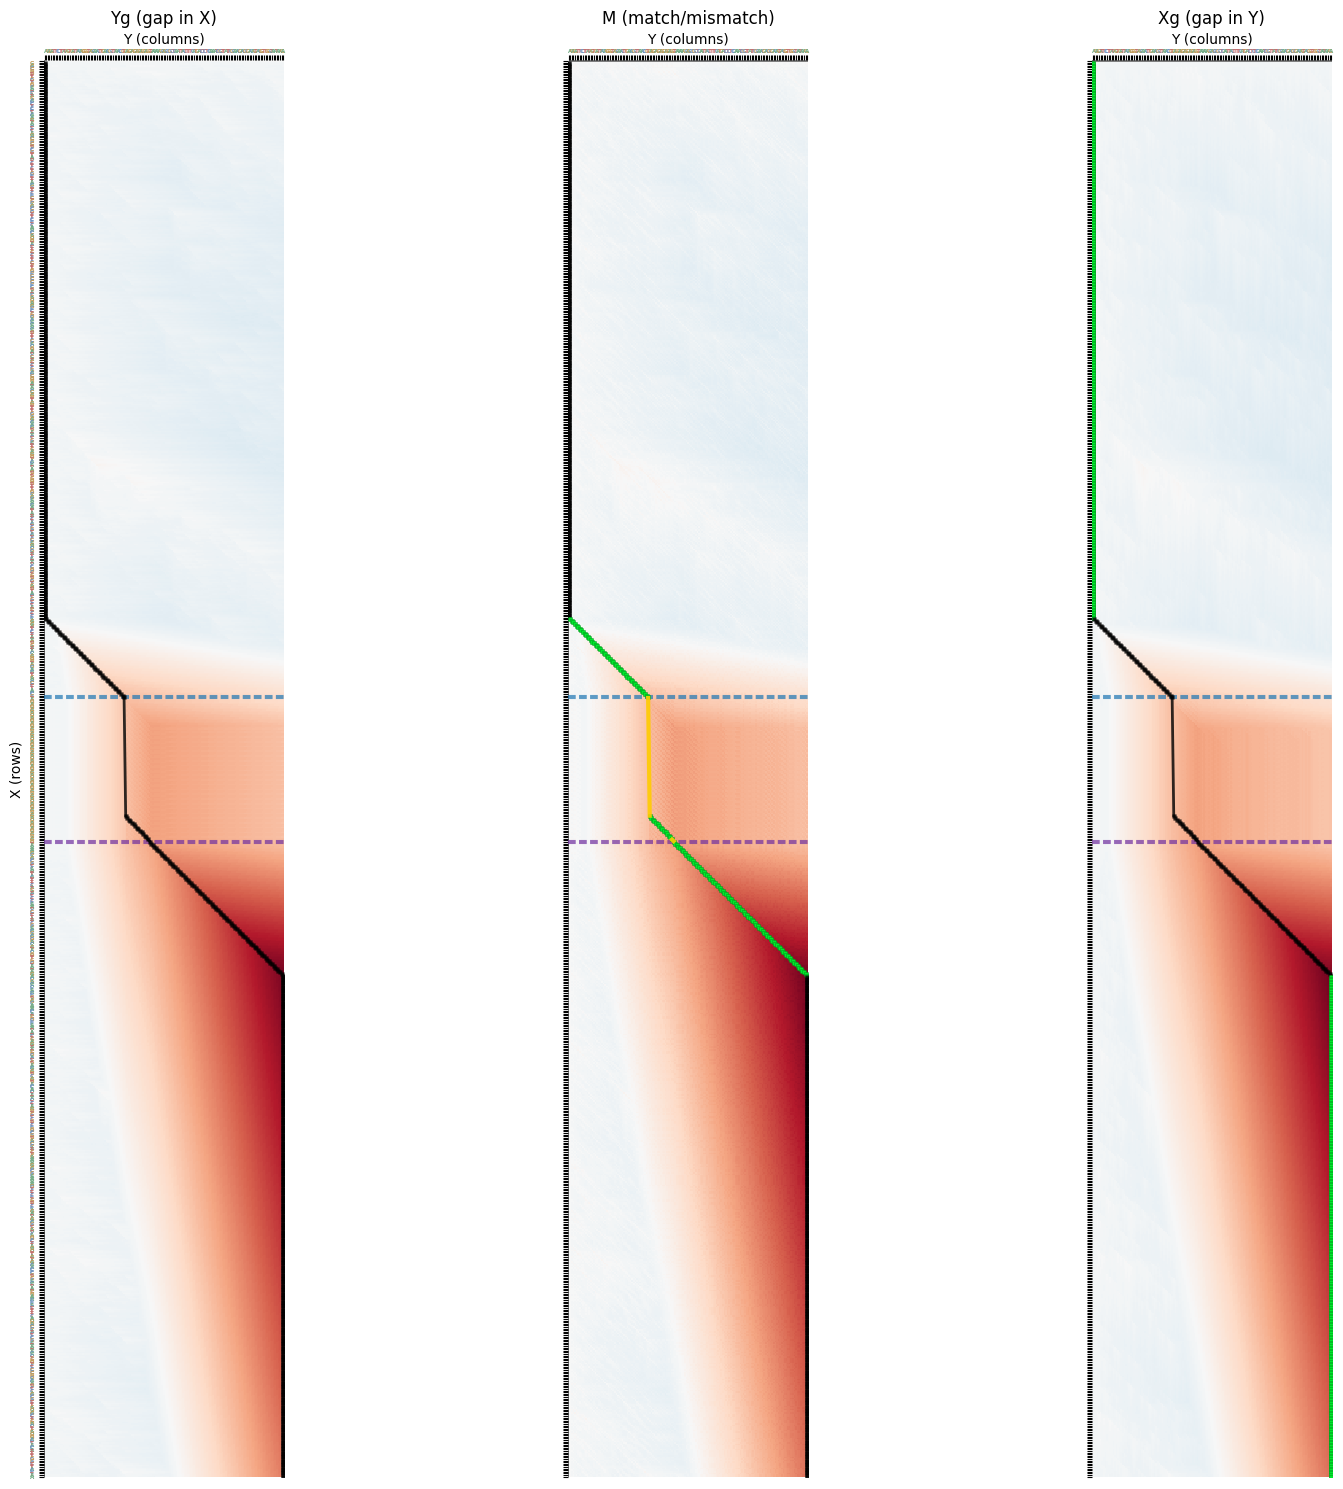

In [67]:
# Normalize Cython data for plotting (convert sentinels to -inf)
# Cython uses a large negative number for -inf, which matplotlib doesn't like for color scaling
CYTHON_SENTINEL = -1e30
for arr in [result.data.Yg, result.data.M, result.data.Xg]:
    arr[arr < CYTHON_SENTINEL] = -np.inf

fig_size = (18, 15)
fig = plot_flex_matrices(
        result=result,
        X=X,
        Y=Y,
        s=locus.s,
        e=locus.e,
        marker_size=1,
        figsize=fig_size,
        annotate=False,
        tick_fontsize=4
    )
plt.show()

## Simulate and Align Multiple Reads (Pileup)

We now simulate a "pileup" of reads sampled from the full locus.

1.  **Sample Reads**: Generate `n_reads` with random start positions from the full locus variant.
2.  **Align**: Align each read to the mapping locus `X` using `run_flex_dp_fast`.
3.  **Visualize**: Display the aligned sequences to observe how they match the reference, especially around the repeat region.

We reuse the `EP` pattern and scoring configuration for efficiency.

In [68]:
# Simulation parameters
n_reads = 5000
M = 5
a = 1
b = 2

# Build variant and sample read
variant = locus_full.build_locus_variant(a, b, M)

# Generate random start positions and sort them
max_start = len(variant) - read_len
start_positions = rng.integers(0, max_start + 1, size=n_reads)
start_positions = np.sort(start_positions)

# Generate reads and align them
results = []
print(f"Aligning {n_reads} reads...")

for i, start_pos in enumerate(start_positions):
    # Extract read
    Y = variant[start_pos : start_pos + read_len]
    
    # Configure alignment (reusing X, EP, scoring)
    config = FlexInput(
        X=X,
        Y=Y,
        score_matrix=score_matrix,
        gap_open=gap_open,
        gap_extend=gap_extend,
        extra_predecessors=EP,
        alphabet_to_index=a2i,
        free_X=True,
        free_Y=True,
    )
    
    # Run fast alignment (no data needed for pileup)
    res = run_flex_dp_fast(config, return_data=False)
    
    # Expand alignment strings
    X_exp, Y_exp = expand_alignment_with_jumps(X, Y, res.path, res.jumps)
    
    results.append({
        "id": i,
        "start_pos": start_pos,
        "score": res.score,
        "X_exp": X_exp,
        "Y_exp": Y_exp,
        "jumps": res.jumps
    })

print("Done.")

Aligning 5000 reads...
Done.


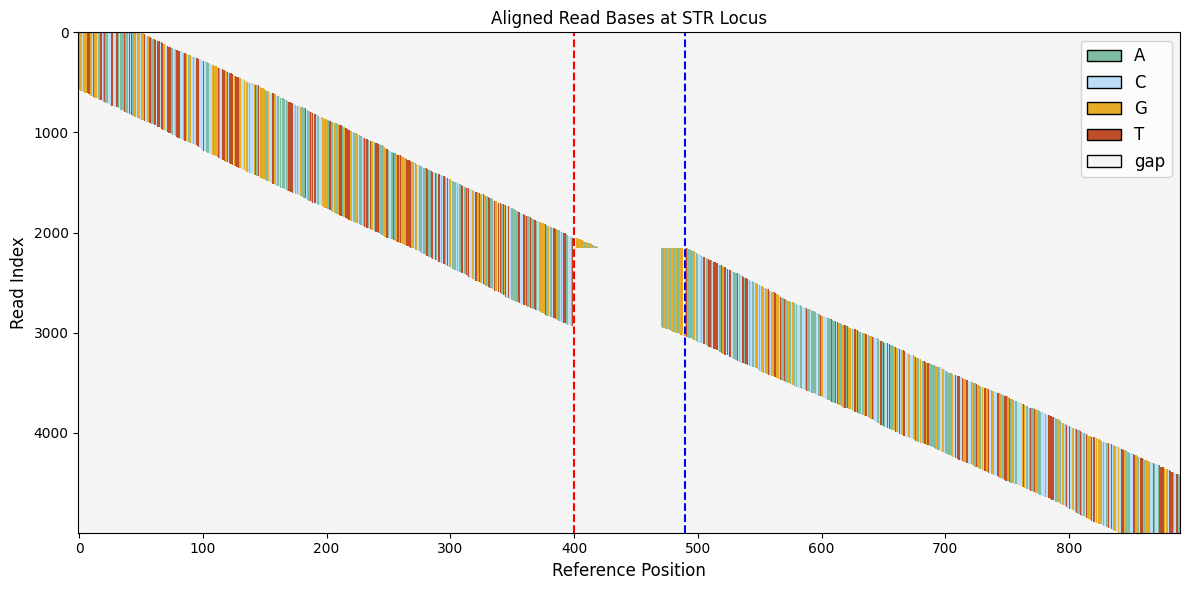

In [69]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

nt_color_map = {
    "A": "#80BCA3",  
    "C": "#BDDEF7",  
    "G": "#E6AC27",
    "T": "#BF4D28"
    }

base_array = -np.ones(shape=(len(results), len(locus.X)), dtype=int)
for ind, res in enumerate(results):
    ybases, xbases = get_aligned_bases(res["X_exp"], res["Y_exp"])
    base_array[ind] = [a2i.get(base, -1) for base in ybases]

# Create custom colormap
# Map -1 to background, and 0..3 to nucleotide colors
bg_color = "whitesmoke"
sorted_nts = sorted(a2i.keys(), key=lambda k: a2i[k])  # ['A', 'C', 'G', 'T']
colors = [bg_color] + [nt_color_map[nt] for nt in sorted_nts]
cmap = ListedColormap(colors)

# Plot with shifted values (-1 becomes index 0)
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(base_array + 1, aspect='auto', cmap=cmap, interpolation='nearest')
ax.set_title("Aligned Read Bases at STR Locus")
ax.set_xlabel("Reference Position", fontsize=12)
ax.set_ylabel("Read Index", fontsize=12)

# Create legend with custom patches
legend_elements = []
for nt in sorted_nts:
    legend_elements.append(Patch(facecolor=nt_color_map[nt], edgecolor="black", label=nt))
legend_elements.append( Patch(facecolor=bg_color, label='gap', edgecolor="black"))
ax.axvline(x=locus.s - 0.5, color='red', linestyle='--', label='Repeat Start')
ax.axvline(x=locus.e - 0.5, color='blue', linestyle='--', label='Repeat End')
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()



## Summary

In this notebook, we demonstrated how to apply NW-flex to a realistic STR alignment scenario:

1.  **Locus Definition**: We distinguished between the **Full Locus** (sampling source) and **Mapping Locus** (alignment reference), creating a realistic semi-global alignment problem.
2.  **Semi-Global Alignment**: By setting `free_X=True` and `free_Y=True`, we allowed reads to partially overlap the reference or extend beyond it without penalty at the ends.
3.  **Phase-Aware Alignment**: Using `build_EP_STR_phase`, we enabled the aligner to handle repeat copy number differences by "jumping" between repeat units while preserving the motif phase.
4.  **Cython Acceleration**: We used `run_flex_dp_fast` to efficiently process multiple reads, showing how the method scales to pileup simulations.

This workflow forms the basis for genotyping STRs from sequencing data, where we must align thousands of reads to a reference locus and infer the consensus repeat sequence.